# Results for ipyrad/pyrad/stacks/aftrRAD/dDocent simulated & emprical analyses

In [144]:
## Prereqs for plotting and analysis
#!conda install matplotlib
#!pip install vcfnp
#!pip install scikit-allel
#!conda install -y seaborn
#!pip install toyplot

    100% |████████████████████████████████| 112kB 2.5MB/s 
    100% |████████████████████████████████| 81kB 1.9MB/s 
    100% |████████████████████████████████| 378kB 624kB/s 
    100% |████████████████████████████████| 2.0MB 467kB/s 
    100% |████████████████████████████████| 5.6MB 121kB/s 
  Running setup.py bdist_wheel for toyplot ... - \ | done
  Stored in directory: /home/iovercast/.cache/pip/wheels/0d/d4/a8/eb794f5aa4840f0604cc5993ff9f97ba051c2fc0ee38d6d020
  Running setup.py bdist_wheel for arrow ... - \ done
  Stored in directory: /home/iovercast/.cache/pip/wheels/02/3c/e7/9c309baa019baa80e0505e7d4a4ceb47458fd750faaad53724
  Running setup.py bdist_wheel for colormath ... - \ | done
  Stored in directory: /home/iovercast/.cache/pip/wheels/26/dd/69/159b685e67e4ab102825a2d265e96aae30fa9bcf0c1b3f50c5
  Running setup.py bdist_wheel for multipledispatch ... - \ done
  Stored in directory: /home/iovercast/.cache/pip/wheels/b0/ba/d3/59749c3611eaa5bd88fd5970976a905e

In [1]:
## Imports and working/output directories directories

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import toyplot
import toyplot.html    ## toypot sublib for saving html plots
import pandas as pd
import numpy as np
import collections
import allel
import vcfnp
import glob
import os

## Set the default directories for exec and data. 
WORK_DIR="/home/iovercast/manuscript-analysis/"
EMPERICAL_DATA_DIR=os.path.join(WORK_DIR, "example_empirical_rad/")
IPYRAD_DIR=os.path.join(WORK_DIR, "ipyrad/")
PYRAD_DIR=os.path.join(WORK_DIR, "pyrad/")
STACKS_DIR=os.path.join(WORK_DIR, "stacks/")
AFTRRAD_DIR=os.path.join(WORK_DIR, "aftrRAD/")
DDOCENT_DIR=os.path.join(WORK_DIR, "dDocent/")

## tmp for testing
#IPYRAD_OUTPUT = "./arch/ipyrad/REALDATA/"
#PYRAD_OUTPUT = "./arch/pyrad/REALDATA/"

os.chdir(WORK_DIR)

## Get sample names, species names, and the species_dict
Next will do some housekeeping to get our empirical samples sorted into species.

In [2]:
## Get sample names and assign them to a species dict
IPYRAD_STATS=os.path.join(IPYRAD_DIR, "REALDATA/REALDATA_outfiles/REALDATA_stats.txt")
infile = open(IPYRAD_STATS).readlines()
sample_names = [x.strip().split()[0] for x in infile[20:33]]
species = set([x.split("_")[1] for x in sample_names])
species_dict = collections.OrderedDict([])

## Ordered dict of sample names and their species, in same order
## as the vcf file
for s in sample_names:
    species_dict[s] = s.split("_")[1]
print(species_dict)

## Map species names to groups of individuals
#for s in species:
#    species_dict[s] = [x for x in sample_names if s in x]
#print(species_dict)
species_colors = {
    'rex': '#FF0000',
    'cyathophylla': '#008000',
    'thamno': '#00FFFF',
    'cyathophylloides': '#90EE90',
    'przewalskii': '#FFA500',
    'superba': '#8B0000',
}

OrderedDict([('29154_superba', 'superba'), ('30556_thamno', 'thamno'), ('30686_cyathophylla', 'cyathophylla'), ('32082_przewalskii', 'przewalskii'), ('33413_thamno', 'thamno'), ('33588_przewalskii', 'przewalskii'), ('35236_rex', 'rex'), ('35855_rex', 'rex'), ('38362_rex', 'rex'), ('39618_rex', 'rex'), ('40578_rex', 'rex'), ('41478_cyathophylloides', 'cyathophylloides'), ('41954_cyathophylloides', 'cyathophylloides')])


## Function for plotting PCA given an input vcf file

In [3]:
def plotPCA(call_data, title):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.despine(ax=ax, offset=5)
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    ## We know this works because the species_dict and the columns in the vcf
    ## are in the same order. 
    for sp in species:
        flt = (np.array(species_dict.values()) == sp)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title+" pca", y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()
    
def plotPairwiseDistance(call_data, title):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=species_dict.keys())

## Function for plotting distribution of variable sites across loci

In [4]:
## Inputs to this function are two Counters where keys
## are the base position and values are snp counts.
## The counter doesn't have to be sorted because we sort internally.
def SNP_position_plot(distvar, distpis):
    
    ## The last position to consider
    maxend = max(distvar.keys())
    
    ## This does two things, first it sorts in increasing
    ## order. Second, it creates a count bin for any position
    ## without snps and sets the count to 0.
    distvar = [distvar[x] for x in xrange(maxend)]
    distpis = [distpis[x] for x in xrange(maxend)]

    ## set color theme
    colormap = toyplot.color.Palette()

    ## make a canvas
    canvas = toyplot.Canvas(width=800, height=300)

    ## make axes
    axes = canvas.cartesian(xlabel="Position along RAD loci",
                       ylabel="N variables sites",
                       gutter=65)
    ## x-axis
    axes.x.ticks.show = True
    axes.x.label.style = {"baseline-shift":"-40px", "font-size":"16px"}
    axes.x.ticks.labels.style = {"baseline-shift":"-2.5px", "font-size":"12px"}
    axes.x.ticks.below = 5
    axes.x.ticks.above = 0
    axes.x.domain.max = maxend
    axes.x.ticks.locator = toyplot.locator.Explicit(
        range(0, maxend, 5), 
        map(str, range(0, maxend, 5)))
    
    ## y-axis
    axes.y.ticks.show=True
    axes.y.label.style = {"baseline-shift":"40px", "font-size":"16px"}
    axes.y.ticks.labels.style = {"baseline-shift":"5px", "font-size":"12px"}
    axes.y.ticks.below = 0
    axes.y.ticks.above = 5

    ## add fill plots
    x = np.arange(0, maxend)
    f1 = axes.fill(x, distvar, color=colormap[0], opacity=0.5, title="total variable sites")
    f2 = axes.fill(x, distpis, color=colormap[1], opacity=0.5, title="parsimony informative sites")

    ## add a horizontal dashed line at the median Nsnps per site
    axes.hlines(np.median(distvar), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    axes.hlines(np.median(distpis), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    
    return canvas, axes

## End housekeeping. Begin actual analysis of results.
The first thing we'll do is create a dataframe for storing a bunch
of coverage information from the runs for each method.

In [5]:
## Make a new pandas dataframe for holding the coverage results
## this is going to 
sim_coverage_df = pd.DataFrame()
sim_missing_df = pd.DataFrame()

## ipyrad simulated results

In [7]:
## ipyrad stats
IPYRAD_SIMOUT=os.path.join(IPYRAD_DIR, "SIMDATA/")
for sim in ["no", "lo", "hi", "large"]:
    print("Doing - {}".format(sim))
    simdir = os.path.join(IPYRAD_SIMOUT, "sim"+sim)
    statsfile = simdir + "/sim{}_outfiles/sim{}_stats.txt".format(sim, sim)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[20:32]]
    #print(sample_coverage)
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_coverage_df["ipyrad_"+sim] = sample_coverage
    
    nmissing = [int(x.strip().split()[1]) for x in infile[38:50]]
    sim_missing_df["ipyrad_"+sim] = nmissing
    #print(nmissing)
print(sim_coverage_df)
print(sim_missing_df)

Doing - no
mean sample coverage - 10000.0
min/max - 10000/10000
Doing - lo
mean sample coverage - 10000.0
min/max - 10000/10000
Doing - hi
mean sample coverage - 9999.91666667
min/max - 9999/10000
Doing - large
mean sample coverage - 96942.6666667
min/max - 96917/96986
    ipyrad_no  ipyrad_lo  ipyrad_hi  ipyrad_large
0       10000      10000      10000         96923
1       10000      10000      10000         96959
2       10000      10000      10000         96931
3       10000      10000      10000         96986
4       10000      10000      10000         96972
5       10000      10000       9999         96933
6       10000      10000      10000         96958
7       10000      10000      10000         96945
8       10000      10000      10000         96917
9       10000      10000      10000         96928
10      10000      10000      10000         96926
11      10000      10000      10000         96934
    ipyrad_no  ipyrad_lo  ipyrad_hi  ipyrad_large
0           0          0      

## pyrad simulated results

In [8]:
## ipyrad stats
PYRAD_SIMOUT=os.path.join(PYRAD_DIR, "SIMDATA/")
for sim in ["no", "lo", "hi", "large"]:
    print("Doing - ", sim)
    simdir = os.path.join(PYRAD_SIMOUT, "sim"+sim)
    statsfile = simdir + "/stats/c85d6m2p3H3N3.stats".format(sim, sim)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[8:20]]
    print(sample_coverage)
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_coverage_df["pyrad_"+sim] = sample_coverage
    
    nmissing = [0] + [int(x.strip().split()[1]) for x in infile[26:37]]
    print(nmissing)
    sim_missing_df["pyrad_"+sim] = nmissing
    #print(nmissing)

print(sim_coverage_df)
print(sim_missing_df)

('Doing - ', 'no')
[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 10000.0
min/max - 10000/10000
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]
('Doing - ', 'lo')
[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 10000.0
min/max - 10000/10000
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]
('Doing - ', 'hi')
[10000, 10000, 10000, 10000, 10000, 9999, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 9999.91666667
min/max - 9999/10000
[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 9998]
('Doing - ', 'large')
[96924, 96960, 96932, 96987, 96973, 96934, 96959, 96946, 96918, 96929, 96927, 96935]
mean sample coverage - 96943.6666667
min/max - 96918/96987
[0, 27, 61, 600, 158, 80, 274, 1851, 1742, 2385, 10113, 82660]
    ipyrad_no  ipyrad_lo  ipyrad_hi  ipyrad_large  pyrad_no  pyrad_lo  \
0       10000      10000      10000         96923     10000     10000   
1       10000      10000    

## stacks simulated results

In [9]:
## stacks stats
STACKS_SIMOUT=os.path.join(STACKS_DIR, "SIMDATA/")
STACKS_GAP_SIMOUT=os.path.join(STACKS_SIMOUT, "gapped/")
STACKS_UNGAP_SIMOUT=os.path.join(STACKS_SIMOUT, "ungapped/")
STACKS_DEFAULT_SIMOUT=os.path.join(STACKS_SIMOUT, "default/")

for dir in [STACKS_GAP_SIMOUT, STACKS_UNGAP_SIMOUT, STACKS_DEFAULT_SIMOUT]:
    #for sim in ["no", "lo", "hi"]:#, "large"]:
    for sim in ["large"]:
        print("Doing - {} - {}".format(dir, sim))
        try:
            simdir = os.path.join(dir, "sim"+sim)
            vcf = pd.read_csv("{}/batch_1.vcf".format(simdir), delim_whitespace=True, header=9, index_col=2)
            sample_counts = {}
            sample_names = list(vcf.columns)[8:]
            print(sample_names)
            uniq_loci = set([x.split("_")[0] for x in vcf.index])
            print("num loci - {}".format(len(uniq_loci)))
            ## Replace the ID index in the stacks vcf file so we can actually evaluate loci
            vcf.index = pd.Index([x.split("_")[0] for x in vcf.index])
            for name in sample_names:
                print(name),
                sample_counts[name] = 0
                for locus in uniq_loci:
                    snps = vcf[name][locus]
                    if any(map(lambda x: x.split(":")[0] != "./.", snps)):
                        sample_counts[name] += 1
                    else:
                        pass
                    #print("{} {} {}".format(name, locus, snps))
            print(sample_counts)
            sim_coverage_df["stacks_"+stacks_method+"_sim"+sim] = sample_coverage
        except:
            print("error getting nloci per sample in {}".format(sim))
print(sim_coverage_df)

Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - no
['1A_0', '1B_0', '1C_0', '1D_0', '2E_0', '2F_0', '2G_0', '2H_0', '3I_0', '3J_0', '3K_0', '3L_0']
num loci - 9893
1A_0 1B_0 1C_0 1D_0 2E_0 2F_0 2G_0 2H_0 3I_0 3J_0 3K_0 3L_0 {'2G_0': 9865, '3K_0': 9864, '3J_0': 9871, '2E_0': 9863, '1A_0': 9870, '1B_0': 9866, '3I_0': 9866, '3L_0': 9868, '2F_0': 9866, '1C_0': 9868, '1D_0': 9867, '2H_0': 9867}
error getting nloci per sample in no
3	11	TA	TA	TA	TA	TA	TA	TA	TA	TA	-	GA	TT

[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 336, 9652]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 336, 9652]
gapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - lo
['1A_0', '1B_0', '1C_0', '1D_0', '2E_0', '2F_0', '2G_0', '2H_0', '3I_0', '3J_0', '3K_0', '3L_0']
num loci - 1512
1A_0 1B_0 1C_0 1D_0 error getting nloci per sample in lo
3	12	TGGAAGA	TTGAAGA	TTGAAGA	TTGAAGA/TTGCACA	TTGAAGA	ATGAAGA/TTGAAGA	TTGAAGA	TTGAAGA	TTGAAGG/TTGACGG	TTAAAGG/TTGAAGG	TTGAAGG	TTGAAGG

[19, 5, 1, 3, 1, 1, 1, 1, 1, 15, 348, 962

In [31]:
STACKS_SIMOUT=os.path.join(STACKS_DIR, "SIMDATA/")
STACKS_GAP_SIMOUT=os.path.join(STACKS_SIMOUT, "gapped/")
STACKS_UNGAP_SIMOUT=os.path.join(STACKS_SIMOUT, "ungapped/")
STACKS_DEFAULT_SIMOUT=os.path.join(STACKS_SIMOUT, "default/")

for dir in [STACKS_GAP_SIMOUT, STACKS_UNGAP_SIMOUT, STACKS_DEFAULT_SIMOUT]:
    for sim in ["no", "lo", "hi", "large"]:
    #for sim in ["large"]:
        print("Doing - {} - {}".format(dir, sim))
        try:
            ## Get levels of missing data
            simdir = os.path.join(dir, "sim"+sim)
            lines = open(os.path.join(simdir, "batch_1.haplotypes.tsv")).readlines()
            #print(lines[3])
            cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
            shigh = [cnts.count(i) for i in range(1,13)]
            nmissing = shigh
            #print(nmissing)
#            nmissing = [int(sum(shigh)-sum(shigh[:i-1])) for i in range(1,13)]

            #print(shigh)
            stacks_method = dir.split("/")[-2]
            print(stacks_method)
            sim_missing_df["stacks_"+stacks_method+"_sim"+sim] = nmissing

        except:
            print("Error in {}".format(simdir))
print(sim_missing_df)

Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - no
gapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - lo
gapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - hi
gapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - large
gapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - no
ungapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - lo
ungapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - hi
ungapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - large
ungapped
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/ - no
default
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/ - lo
default
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/ - hi
default
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/ - large
default
    ipyrad_no  ipyr

## AftrRAD simulated results
AftrRAD doesn't natively support vcf. the vcf files we made
are in sim\*/Formatting/sim\*.vcf

It's not straightforward how to get the locations for snps
from the output files. aftrRAD does calculate and write these out
as part of the Genotype.pl phase to a file called __/TempFiles/SNPLocationsToPlot.txt__

It's also not straightforward how to get the number of loci recovered for each invidual.
You have to total up the counts from two different files for each individual. The
`Outputs/Genotypes` directory has two files, one for `Haplotypes` and one for `Monomorphics`.
The haplotypes file is a giant matrix of concatenated snps per locus so you have to 
search through each column to count up all the `NA`'s (missing data per locus per individual).
Then you have to count up the number of non-zero monomorphic sites.

In [255]:
AFTRRAD_SIMOUT=os.path.join(AFTRRAD_DIR, "SIMDATA/")
#for sim in ["no", "lo", "hi", "large"]:
for sim in ["no"]:
    print("Doing - sim{}".format(sim))
    simdir = os.path.join(AFTRRAD_SIMOUT, "sim"+sim)
    ## The `17` in the file name is the min % of samples w/ data
    hapsfile = simdir + "/Output/Genotypes/Haplotypes_17.All.txt"
    monofile = simdir + "/Output/Genotypes/Monomorphics_17.txt"

    mono_df = pd.read_csv(monofile, delim_whitespace=True, header=0)
    haps_df = pd.read_csv(hapsfile, delim_whitespace=True, header=0, index_col=0)

    sample_coverage = {}
    ## Get the list of all the simulated sample names
    samplenames = mono_df.columns.values[1:]
    ## Do haplotypes file first because it is phased so there are 2 rows per sample
    ## so we end up double counting NA's. If you read the # of monomorphics first
    ## then you have to figure out some way to prevent the double counting, here
    ## we just count twice and overwrite.
    for row in haps_df.itertuples():        
        sample_coverage[row[0].split("Individual")[1]] = len(pd.Series(row).nonzero()[0])

    for sname in samplenames:
        ## nonzero returns a tuple of which we are only interested in the first element
        sample_coverage[sname] += len(mono_df[sname].nonzero()[0])

    ## To sort or not to sort the coverage_df?
    print(sorted(sample_coverage.values(), reverse=True))
    
    print("mean sample coverage - {}".format(np.mean(sample_coverage.values())))
    print("min/max - {}/{}".format(np.min(sample_coverage.values()), np.max(sample_coverage.values())))
    sim_coverage_df["aftrrad_"+sim] = sample_coverage.values()
    
    
print(sim_coverage_df)

('Doing - ', 'no')
[10023, 10022, 10021, 10021, 10019, 10019, 10018, 10018, 10018, 10018, 10017]
mean sample coverage - 10019.4545455
min/max - 10017/10023


ValueError: Length of values does not match length of index

## dDocent simulated results
Here's what's weird. The dDocent reference.fasta file which is generated by the cd-hit clustering looks like it contains the right number of clusters. Similarly, if you use samtools to view the sample `-RG.bam`, and the `mapped.bed` file has 10000 loci as well. But if you look at the Contigs that make it to the final vcf files (either TotalRawSNPs or Final.recode) there are ~100+ contigs missing. I'm sure freebayes is filtering loci, but i diff'd the loci in the bed file and the vcf, and looked at the sequences of one of the missing loci in the cat-RRG.bam file and they look more or less normal. It's not the mapping quality flaq (-m), because all sim seqs have high quality mapping. None of the other settings in the dDocent script or the default freebayes settings seem particularly conspicuous.

        grep Contig TotalRawSNPs.vcf | cut -f 1 | uniq -c | wc -l
        
simno/simlo/simhi - 9887/9889/9890

For simlarge there was a much bigger difference between the TotalRaw and Final.recode vcf files (98350/91620), TotalRaw recovers about 98.4% of true loci, but the final recode catches only about 92%.

It's also not super straightforward how to get # loci per sample from the dDocent output, so 
I had to gin something up. Right now because it uses samtools to view the bam file and then does
some shell manipulation, this is a little slow (20 seconds per simulation treatment), but tolerable.

TODO: This is currently not tracking __which__ samples correspond with the number of loci recovered
bcz the ddocent bam files use the weird naming scheme and I haven't back calculated the good names yet.

This isn't exactly technically correct, because this is the counts of loci mapped for each individual,
not the number of loci for each individual in the output!

In [67]:
import subprocess

DDOCENT_SIMOUT=os.path.join(DDOCENT_DIR, "SIMDATA/")
for sim in ["no", "lo", "hi", "large"]:
    print("Doing - sim{}".format(sim))
    ## This is hackish
    simdir = os.path.join(DDOCENT_SIMOUT, "sim"+sim+"/sim"+sim+"_fastqs/")
    sample_coverage = []
    for samp in glob.glob(simdir + "/*-RG.bam"):
        cmd = "{}samtools view {} | cut -f 3 | uniq | wc -l".format(DDOCENT_DIR, samp)
        res = subprocess.check_output(cmd, shell=True)
        sample_coverage.append(int(res.strip()))
    
    print(sorted(sample_coverage, reverse=True))
    
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_coverage_df["ddocent_"+sim] = sample_coverage
    
    vcf_filt = pd.read_csv("{}/Final.recode.vcf".format(simdir), delim_whitespace=True, header=60, index_col=0)
    vcf_full = pd.read_csv("{}/TotalRawSNPs.vcf".format(simdir), delim_whitespace=True, header=60, index_col=0)

    ## There's gotta be a faster way to do this...
    for vcf in [vcf_full, vcf_filt]:
        sample_counts = {}
        sample_names = list(vcf.columns)[8:]
        print(sample_names)
        print("num loci - {}".format(len(set(vcf.index))))
        for name in sample_names:
            print(name)
            sample_counts[name] = 0
            for locus in set(vcf.index):
                snps = vcf[name][locus]
                if any(map(lambda x: x.split(":")[0] != "./.", snps)):
                    sample_counts[name] += 1
                else:
                    pass
                    #print("{} {} {}".format(name, locus, snps))
        print(sample_counts)
print(sim_coverage_df)

Doing - simno
[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 10000.0
min/max - 10000/10000
['Pop1_SampleA', 'Pop1_SampleB', 'Pop1_SampleC', 'Pop1_SampleD', 'Pop2_SampleE', 'Pop2_SampleF', 'Pop2_SampleG', 'Pop2_SampleH', 'Pop3_SampleI', 'Pop3_SampleJ', 'Pop3_SampleK', 'Pop3_SampleL']
num loci - 9886
Pop1_SampleA
Pop1_SampleB
Pop1_SampleC
Pop1_SampleD
Pop2_SampleE
Pop2_SampleF
Pop2_SampleG
Pop2_SampleH
Pop3_SampleI
Pop3_SampleJ
Pop3_SampleK
Pop3_SampleL
{'Pop1_SampleB': 9886, 'Pop2_SampleH': 9886, 'Pop1_SampleA': 9886, 'Pop2_SampleG': 9886, 'Pop1_SampleC': 9886, 'Pop2_SampleE': 9886, 'Pop1_SampleD': 9886, 'Pop2_SampleF': 9886, 'Pop3_SampleL': 9886, 'Pop3_SampleK': 9886, 'Pop3_SampleJ': 9886, 'Pop3_SampleI': 9886}
['Pop1_SampleA', 'Pop1_SampleB', 'Pop1_SampleC', 'Pop1_SampleD', 'Pop2_SampleE', 'Pop2_SampleF', 'Pop2_SampleG', 'Pop2_SampleH', 'Pop3_SampleI', 'Pop3_SampleJ', 'Pop3_SampleK', 'Pop3_SampleL']
num loci - 9886
Pop1_Samp

KeyboardInterrupt: 

In [66]:
#!pip install tabulate
#!pip install plotly
from tabulate import tabulate
print("num loci - {}".format(len(set(vcf.index))))
print(sample_counts)
#print(tabulate(sim_missing_df, headers="keys"))
print(sim_missing_df)

num loci - 50155
{'29154_superba': 38958, '30686_cyathophylla': 15214, '30556_thamno': 41418}
    ipyrad_no  ipyrad_lo  ipyrad_hi  ipyrad_large  pyrad_no  pyrad_lo  \
0           0          0          0             0         0         0   
1           0          0          0            27         0         0   
2           0          0          0            61         0         0   
3           0          0          1           600         0         0   
4           0          0          0           158         0         0   
5           0          0          0            80         0         0   
6           0          0          0           274         0         0   
7           0          0          1          1851         0         0   
8           0          0          0          1742         0         0   
9           0          0          0          2385         0         0   
10          0          0          1         10113         0         0   
11      10000      10000      

## Plotting simulation results

Mean sample coverage:


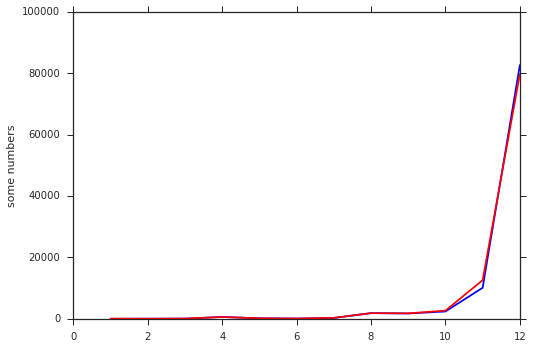

In [68]:
print("Mean sample coverage:")
#for col in sim_coverage_df:
#    print("\t{} - {}".format(col, np.mean(sim_coverage_df[col])))
#print(sim_missing_df)
x = np.arange(1,13)
#print(len(sim_missing_df["ipyrad_large"]))
plt.plot(x, sim_missing_df["ipyrad_large"], 'b-')
plt.plot(x, sim_missing_df["stacks_gapped_simlarge"], 'r-')
plt.ylim(0,100000)
plt.xlim(0,12)
plt.ylabel('some numbers')
plt.show()


# Empirical Results (Pedicularis)

## Process the vcf output from all the runs
Here we'll pull together all the output vcf files and filter
out everything except biallelic snps

In [ ]:
vcf_dict = {}
vcf_dict["ipyrad"] = os.path.join(IPYRAD_DIR, "REALDATA/REALDATA_outfiles/REALDATA.vcf")
vcf_dict["pyrad"] = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
vcf_dict["stacks_ungapped"] = os.path.join(STACKS_DIR, "REALDATA/ungapped/batch_1.vcf")
vcf_dict["stacks_gapped"] = os.path.join(STACKS_DIR, "REALDATA/gapped/batch_1.vcf")
vcf_dict["stacks_defualt"] = os.path.join(STACKS_DIR, "REALDATA/default/batch_1.vcf")
vcf_dict["aftrrad"] = os.path.join(AFTRRAD_DIR, "REALDATA/Formatting/REALDATA.vcf")
vcf_dict["ddocent_full"] = os.path.join(DDOCENT_DIR, "REALDATA/TotalRawSNPs.vcf")
vcf_dict["ddocent_filt"] = os.path.join(DDOCENT_DIR, "REALDATA/Final.recode.vcf")
for k, f in vcf_dict.items():
    if os.path.exists(f):
        print("found - {}".format(f))
        
        ## If it's gzipped then unzip it (only applies to ipyrad i think)
        if ".gz" in f:
            print("gunzipping")
            cmd = "gunzip {}".format(f)
            !cmd
            f = f.split(".gz")[0]
            
        ## Remove all but biallelic (for ipyrad this also removes all the monomorphic)
        outfile = f.split(".vcf")[0]+"biallelic.vcf"
        cmd = "{}vcftools --vcf {} --min-alleles 2 --max-alleles 2 --recode --out {}" \
            .format(DDOCENT_DIR, f, outfile)
        print(cmd)
        !$cmd
        
        ## update the vcf_dict
        vcf_dict[k] = outfile
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPs.vcf
/home/iovercast/manuscript-analysis/dDocent/vcftools --vcf /home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPs.vcf --min-alleles 2 --max-alleles 2 --recode --out /home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPsbiallelic.vcf

VCFtools - v0.1.11
(C) Adam Auton 2009

Parameters as interpreted:
	--vcf /home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPs.vcf
	--max-alleles 2
	--min-alleles 2
	--out /home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPsbiallelic.vcf
	--recode

Index file is older than variant file. Will regenerate.
Building new index file.
	Scanning Chromosome: dDocent_Contig_1
	Scanning Chromosome: dDocent_Contig_3
	Scanning Chromosome: dDocent_Contig_4
	Scanning Chromosome: dDocent_Contig_5
	Scanning Chromosome: dDocent_Contig_6
	Scanning Chromosome: dDocent_Contig_7
	Scanning Chromosome: dDocent_Contig_8
	Scanning Chromosome: dDocent_Contig_

## ipyrad Empirical results
First we load in the variant info and call data for all the snps

In [70]:
IPYRAD_EMPIRICAL_OUTPUT=os.path.join(IPYRAD_DIR, "REALDATA/")
IPYRAD_STATS = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA_stats.txt")

infile = open(IPYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[20:33]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[21163, 31863, 27902, 20852, 17779, 23008, 33289, 33697, 35765, 29184, 35096, 38144, 34746]
mean sample coverage - 29422.1538462
min/max - 17779/38144


Read the biallelic vcf

In [71]:
filename = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA.biallelic.vcf")
# filename = vcf_dict["ipyrad"]
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 12:42:26.099077 :: caching is disabled
[vcfnp] 2016-10-12 12:42:26.099836 :: building array
[vcfnp] 2016-10-12 12:42:29.441796 :: caching is disabled
[vcfnp] 2016-10-12 12:42:29.442748 :: building array


### Distribution of snps along loci
Getting variable sites and parsimony informative sites from the vcf is kind of annoying
because all the programs export __slightly__ different formats, so you need to
parse them in slightly different ways. There's a better way to do this for ipyrad
but i figure i'll do it the same way for all of them so it's more clear what's happening.

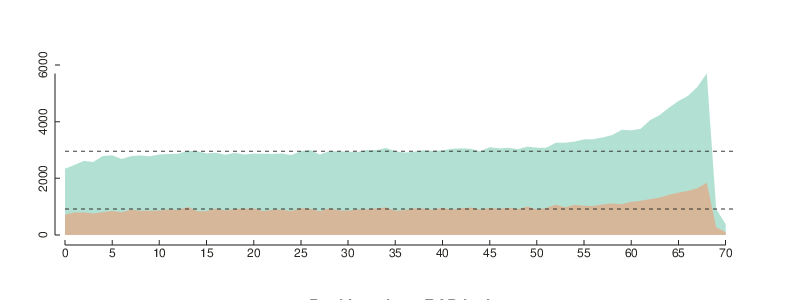

In [72]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x) for x in v.POS])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

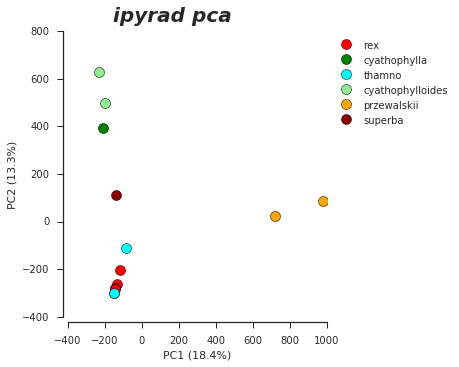

In [113]:
## Have to gunzip the ipyrad REALDATA vcf
plotPCA(c, "ipyrad")

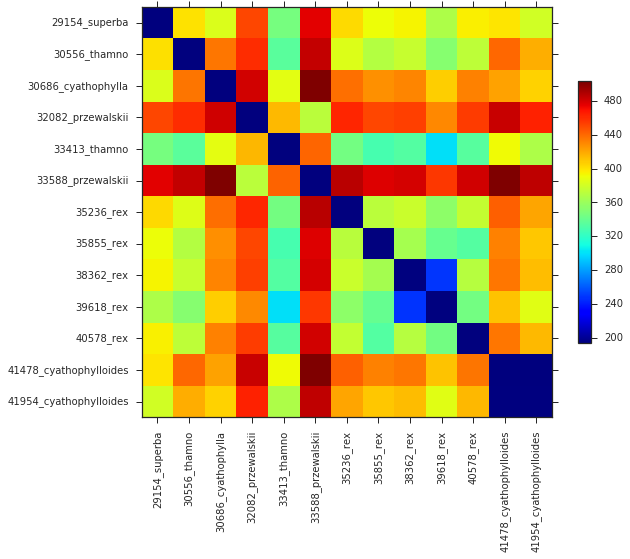

In [114]:
plotPairwiseDistance(c, "pyrad")

## pyRAD empirical results

#### TODO: Figure out why vcfnp is failing to read in pyrad vcf

In [196]:
PYRAD_EMPIRICAL_OUTPUT=os.path.join(PYRAD_DIR, "REALDATA/")
PYRAD_STATS = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "stats/c85d6m2p3H3N3.stats")

infile = open(PYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[8:21]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[23924, 37002, 31852, 23698, 20063, 26050, 38931, 39423, 41250, 33230, 40809, 42948, 38645]
mean sample coverage - 33678.8461538
min/max - 20063/42948


### Pull in the pyrad vcf
Be careful because sometimes the pyrad vcf gets a newline inserted between the last
line of metadata and the first line of genotypes, which causes vcfnp to silently fail.
Also there are a couple flags you can pass to vcfnp for debugging, but the print 
hella data to the console.

    v = vcfnp.variants(filename, progress=1, verbose=True).view(np.recarray)

In [230]:
filename = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-08 15:40:30.499958 :: caching is disabled
[vcfnp] 2016-10-08 15:40:30.500883 :: building array
[vcfnp] 2016-10-08 15:40:37.399061 :: caching is disabled
[vcfnp] 2016-10-08 15:40:37.417059 :: building array


### Distribution of snps along loci

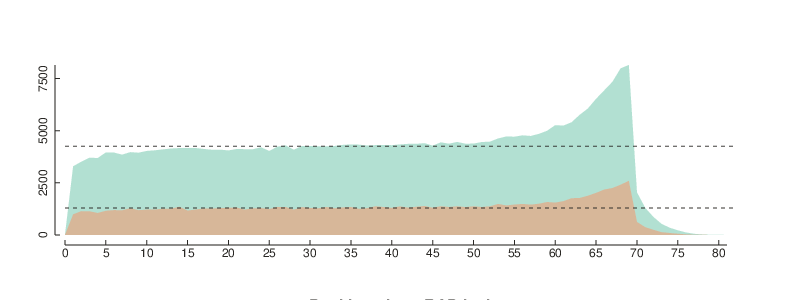

In [231]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x) for x in v.POS])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

[vcfnp] 2016-09-03 18:32:22.899103 :: caching is disabled
[vcfnp] 2016-09-03 18:32:22.899671 :: building array


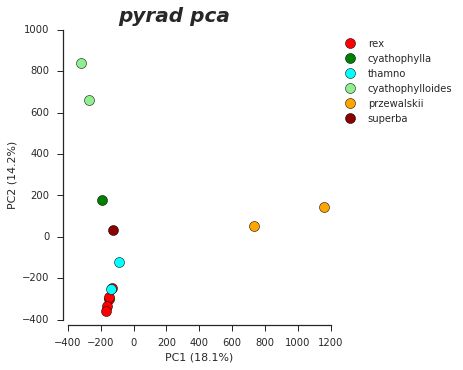

In [76]:
plotPCA(c, "pyrad")

[vcfnp] 2016-09-03 21:48:18.232723 :: caching is disabled
[vcfnp] 2016-09-03 21:48:18.233306 :: building array


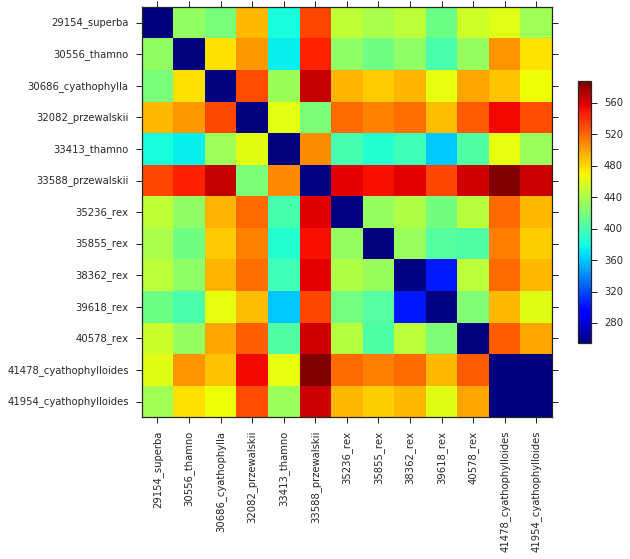

In [18]:
plotPairwiseDistance(c, "pyrad")

## stacks empirical results (ungapped)

In [12]:
STACKS_OUTPUT=os.path.join(STACKS_DIR, "REALDATA/")
STACKS_GAP_OUT=os.path.join(STACKS_OUTPUT, "gapped/")
STACKS_UNGAP_OUT=os.path.join(STACKS_OUTPUT, "ungapped/")
STACKS_DEFAULT_OUT=os.path.join(STACKS_OUTPUT, "default/")

#lines = open("SIMsmall/stackf_high/batch_1.haplotypes.tsv").readlines()
#cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
#shigh = [cnts.count(i) for i in range(1,13)]

In [13]:
filename = os.path.join(STACKS_UNGAP_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 10:48:17.512074 :: caching is disabled
[vcfnp] 2016-10-12 10:48:17.512879 :: building array
[vcfnp] 2016-10-12 10:48:25.055213 :: caching is disabled
[vcfnp] 2016-10-12 10:48:25.061273 :: building array


### Distribution of snps along loci

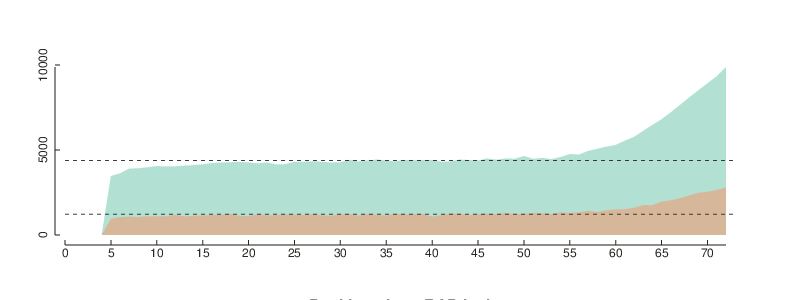

In [14]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["ID"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x.split("_")[1]) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x.split("_")[1]) for x in v.ID])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

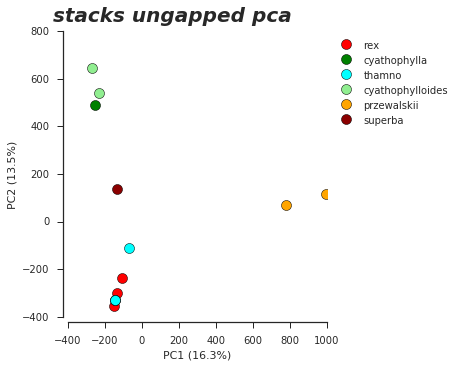

In [15]:
plotPCA(c, "stacks ungapped")

[vcfnp] 2016-09-03 19:04:05.829749 :: caching is disabled
[vcfnp] 2016-09-03 19:04:05.830278 :: building array


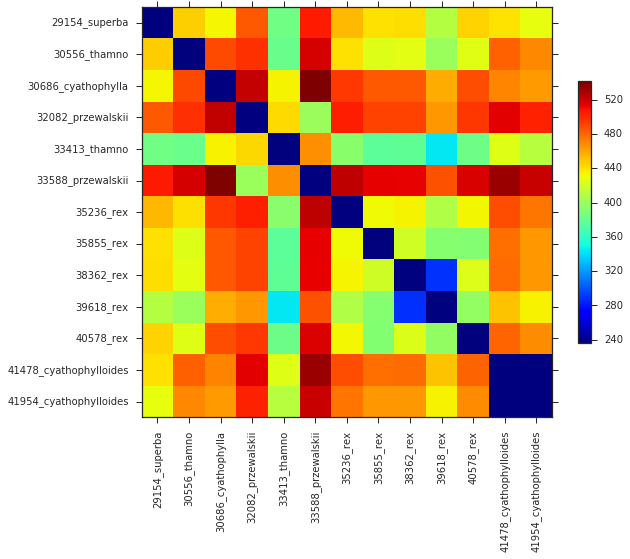

In [16]:
plotPairwiseDistance(c, "stacks ungapped")

## stacks empirical results (defaults)

In [16]:
filename = os.path.join(STACKS_DEFAULT_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 10:53:17.257960 :: caching is disabled
[vcfnp] 2016-10-12 10:53:17.259180 :: building array
[vcfnp] 2016-10-12 10:53:20.403885 :: caching is disabled
[vcfnp] 2016-10-12 10:53:20.409034 :: building array


### Some informative stats
TODO

### Distribution of snps along loci

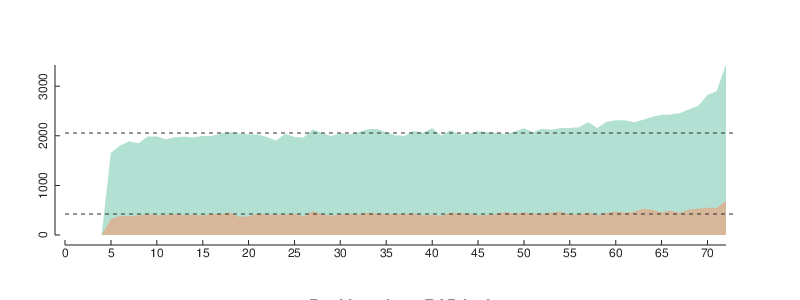

In [17]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["ID"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x.split("_")[1]) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x.split("_")[1]) for x in v.ID])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
toyplot.html.render(canvas, 'snp_positions.html')

canvas

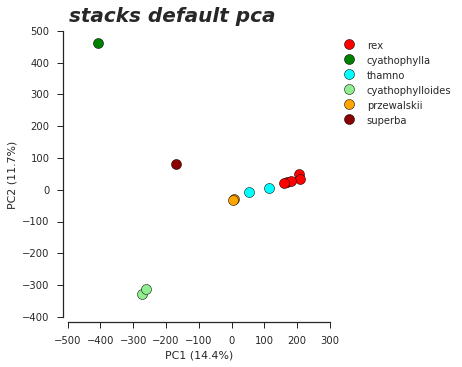

In [18]:
plotPCA(c, "stacks default")

[vcfnp] 2016-09-03 18:56:31.855138 :: caching is disabled
[vcfnp] 2016-09-03 18:56:31.855756 :: building array


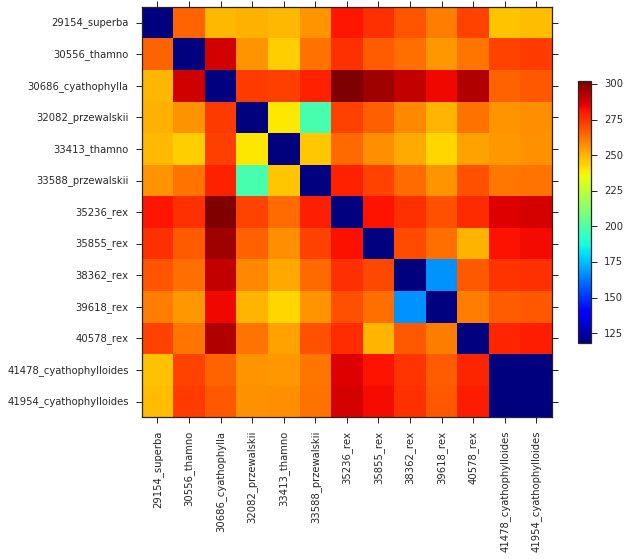

In [12]:
plotPairwiseDistance(c, "stacks default")

## AftrRAD empirical results

In [ ]:
AFTRRAD_OUTPUT=os.path.join(AFTRRAD_DIR, "REALDATA/")

In [ ]:
filename = os.path.join(STACKS_DEFAULT_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

### Distribution of snps along loci
NOT TESTED

It's not very straightforward how to extract information about
whether each snp is informative or not, given the output files
that aftrRAD generates. It does create a file with all the snp
locations so we can use this to generate the distribution of 
variable sites, but the pis will be empty.

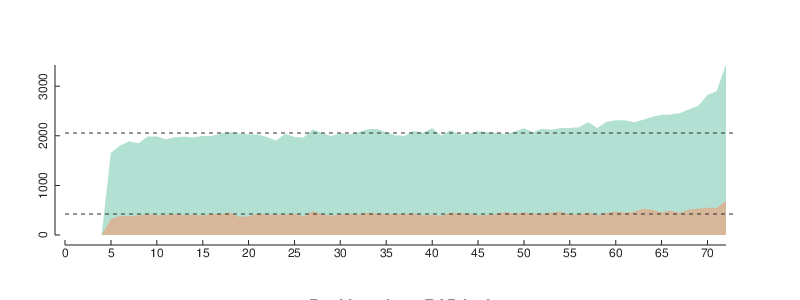

In [184]:
f = os.path.join(AFTRRAD_OUTPUT, "TempFiles/SNPLocationsToPlot.txt")
with open(f) as infile:
    snplocs = infile.read().split()
## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([])

## Getting the distvar is easier
distvar = Counter(map(int, snplocs))

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
## toyplot.html.render(canvas, 'snp_positions.html')

canvas

## dDocent empirical results
HAVE TO MAKE SURE THE SAMPLES IN THE DDOCENT OUTPUT VCF ARE IN THE SAME ORDER AS THOSE IN THE IPYRAD/STACKS
There is now code in the horserace notebook to rename samples in the ddocent
vcf and to reorder the samples to match ipyrad/stacks.

In [ ]:
import subprocess

DDOCENT_OUTPUT=os.path.join(DDOCENT_DIR, "REALDATA/")
os.chdir(DDOCENT_OUTPUT)
print("Getting max loci per sample from bam files.")
sample_coverage = []
for samp in glob.glob("*-RG.bam"):
    cmd = "{}samtools view {} | cut -f 3 | uniq | wc -l".format(DDOCENT_DIR, samp)
    res = subprocess.check_output(cmd, shell=True)
    print("nloci {} - {}".format(res.strip(), samp))
    sample_coverage.append(int(res.strip()))
    
print(sorted(sample_coverage, reverse=True))
    
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
#sim_coverage_df["ddocent_"+sim] = sample_coverage
    
vcf_filt = pd.read_csv("Final.recode.vcf", delim_whitespace=True, header=60, index_col=0)
vcf_full = pd.read_csv("TotalRawSNPs.vcf", delim_whitespace=True, header=60, index_col=0)

## There's gotta be a faster way to do this...
## It's really fuckin slow on real data, like hours.
for vcf in [vcf_full, vcf_filt]:
    sample_counts = {}
    sample_names = list(vcf.columns)[8:]
    print(sample_names)
    print("num loci in vcf - {}".format(len(set(vcf.index))))
    for name in sample_names:
        print(name)
        sample_counts[name] = 0
        for locus in set(vcf.index):
            snps = vcf[name][locus]
            if any(map(lambda x: x.split(":")[0] != "./.", snps)):
                sample_counts[name] += 1
            else:
                pass
    print(sample_counts)
print(sim_coverage_df)

Getting max loci per sample from bam files.
nloci 37358 - Pop1_Sample1-RG.bam
nloci 41001 - Pop3_Sample1-RG.bam
nloci 29663 - Pop2_Sample2-RG.bam
nloci 42706 - Pop3_Sample2-RG.bam
nloci 29490 - Pop2_Sample1-RG.bam
nloci 38202 - Pop4_Sample2-RG.bam
nloci 42543 - Pop3_Sample3-RG.bam
nloci 42667 - Pop3_Sample4-RG.bam
nloci 42999 - Pop3_Sample5-RG.bam
nloci 43950 - Pop4_Sample1-RG.bam
nloci 44300 - Pop4_Sample3-RG.bam
nloci 40740 - Pop5_Sample1-RG.bam
nloci 39368 - Pop5_Sample2-RG.bam
[44300, 43950, 42999, 42706, 42667, 42543, 41001, 40740, 39368, 38202, 37358, 29663, 29490]
mean sample coverage - 39614.3846154
min/max - 29490/44300


In [74]:
## Basic difference btw Final.recode and TotalRawSNPs is that final recode
## only includes individuals with snps called in > 90% of samples

f1 = os.path.join(DDOCENT_OUTPUT, "TotalRawSNPs.vcf")
v_full = vcfnp.variants(f1).view(np.recarray)
c_full = vcfnp.calldata_2d(f1).view(np.recarray)
f2 = os.path.join(DDOCENT_OUTPUT, "Final.recode.vcf")
v_filt = vcfnp.variants(f2).view(np.recarray)
c_filt = vcfnp.calldata_2d(f2).view(np.recarray)

[vcfnp] 2016-10-12 12:56:37.651587 :: caching is disabled
[vcfnp] 2016-10-12 12:56:37.652428 :: building array
[vcfnp] 2016-10-12 12:57:04.658723 :: caching is disabled
[vcfnp] 2016-10-12 12:57:04.659833 :: building array
[vcfnp] 2016-10-12 12:58:36.334946 :: caching is disabled
[vcfnp] 2016-10-12 12:58:36.336141 :: building array
[vcfnp] 2016-10-12 12:58:48.131876 :: caching is disabled
[vcfnp] 2016-10-12 12:58:48.143038 :: building array


### Distribution of snps along loci

In [75]:
for dset in [[v_full, c_full], [v_filt, c_filt]]:
    ## Get only parsimony informative sites
    ## Get T/F values for whether each genotype is ref or alt across all samples/loci
    is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), dset[1]["genotype"])
    ## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
    alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
    ## Create a T/F mask for snps that are informative
    only_pis = map(lambda x: x < 2, alt_counts)
    ## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
    ## Also, compress() the masked array so we only actually see the pis
    pis = np.ma.array(np.array(dset[0]["POS"]), mask=only_pis).compressed()

    ## Now have to massage this into the list of counts per site in increasing order 
    ## of position across the locus
    distpis = Counter([int(x) for x in pis])

    ## Getting the distvar is easier
    distvar = Counter([int(x) for x in v_filt.POS])

    canvas, axes = SNP_position_plot(distvar, distpis)

    ## save fig
    ## toyplot.html.render(canvas, 'snp_positions.html')

    canvas

<polygon points="65.0,235.0 73.933333333333337,235.0 82.866666666666674,235.0 91.799999999999997,235.0 100.73333333333333,235.0 109.66666666666666,235.0 118.60000000000001,235.0 127.53333333333333,235.0 136.46666666666667,235.0 145.40000000000001,235.0 154.33333333333334,235.0 163.26666666666665,235.0 172.20000000000002,235.0 181.13333333333333,235.0 190.06666666666669,235.0 199.0,235.0 207.93333333333334,235.0 216.86666666666667,235.0 225.80000000000001,235.0 234.73333333333335,235.0 243.66666666666669,235.0 252.60000000000002,235.0 261.5333333333333,235.0 270.46666666666664,235.0 279.40000000000003,235.0 288.33333333333331,235.0 297.26666666666665,235.0 306.19999999999999,235.0 315.13333333333338,235.0 324.06666666666666,235.0 333.0,235.0 341.93333333333334,235.0 350.86666666666667,235.0 359.79999999999995,235.0 368.73333333333335,235.0 377.66666666666669,235.0 386.60000000000002,235.0 395.53333333333336,235.0 404.4666666666667,235.0 413.39999999999998,235.0 422.33333333333331,235.0 431.26666666666665,235.0 440.20000000000005,235.0 449.13333333333338,235.0 458.06666666666666,235.0 467.0,235.0 475.93333333333328,235.0 484.86666666666667,235.0 493.80000000000001,235.0 502.73333333333335,235.0 511.66666666666669,235.0 520.60000000000002,235.0 529.5333333333333,235.0 538.4666666666667,235.0 547.39999999999998,235.0 556.33333333333337,235.0 565.26666666666677,235.0 574.20000000000005,235.0 583.13333333333333,235.0 592.06666666666661,235.0 601.0,235.0 609.93333333333339,235.0 618.86666666666667,235.0 627.79999999999995,235.0 636.73333333333335,235.0 645.66666666666663,235.0 654.59999999999991,235.0 663.5333333333333,235.0 672.4666666666667,235.0 681.40000000000009,235.0 690.33333333333337,235.0 699.26666666666665,235.0 708.20000000000005,235.0 717.13333333333344,235.0 726.06666666666672,235.0 726.06666666666672,147.54668930390494 717.13333333333344,156.92699490662136 708.20000000000005,145.16553480475383 699.26666666666665,137.58913412563666 690.33333333333337,143.14516129032259 681.40000000000009,138.02207130730051 672.4666666666667,136.57894736842104 663.5333333333333,133.98132427843802 654.59999999999991,132.17741935483872 645.66666666666663,126.40492359932088 636.73333333333335,134.48641765704582 627.79999999999995,131.74448217317487 618.86666666666667,126.91001697792871 609.93333333333339,134.63073005093378 601.0,132.46604414261461 592.06666666666661,127.48726655348048 583.13333333333333,133.47623089983023 574.20000000000005,128.13667232597624 565.26666666666677,121.64261460101869 556.33333333333337,133.54838709677418 547.39999999999998,126.76570458404075 538.4666666666667,125.75551782682513 529.5333333333333,125.89983022071308 520.60000000000002,123.08573853989813 511.66666666666669,122.50848896434636 502.73333333333335,132.10526315789474 493.80000000000001,126.98217317487268 484.86666666666667,130.80645161290323 475.93333333333328,134.12563667232598 467.0,124.81748726655348 458.06666666666666,122.58064516129033 449.13333333333338,132.03310696095076 440.20000000000005,126.40492359932088 431.26666666666665,124.31239388794569 422.33333333333331,131.31154499151103 413.39999999999998,136.00169779286927 404.4666666666667,126.83786078098471 395.53333333333336,130.51782682512732 386.60000000000002,128.56960950764005 377.66666666666669,122.3641765704584 368.73333333333335,134.77504244482174 359.79999999999995,127.99235993208829 350.86666666666667,129.79626485568761 341.93333333333334,137.58913412563666 333.0,132.89898132427842 324.06666666666666,126.54923599320882 315.13333333333338,133.40407470288625 306.19999999999999,134.63073005093378 297.26666666666665,129.94057724957557 288.33333333333331,134.5585738539898 279.40000000000003,131.02292020373517 270.46666666666664,127.34295415959252 261.5333333333333,132.24957555178267 252.60000000000002,129.94057724957557 243.66666666666669,123.37436332767402 234.73333333333335,131.52801358234296 225.80000000000001,135.1358234295416 216.86666666666667,129.94057724957557 207.93333333333334,136.6

<polygon points="65.0,235.0 73.933333333333337,235.0 82.866666666666674,235.0 91.799999999999997,235.0 100.73333333333333,235.0 109.66666666666666,235.0 118.60000000000001,235.0 127.53333333333333,235.0 136.46666666666667,235.0 145.40000000000001,235.0 154.33333333333334,235.0 163.26666666666665,235.0 172.20000000000002,235.0 181.13333333333333,235.0 190.06666666666669,235.0 199.0,235.0 207.93333333333334,235.0 216.86666666666667,235.0 225.80000000000001,235.0 234.73333333333335,235.0 243.66666666666669,235.0 252.60000000000002,235.0 261.5333333333333,235.0 270.46666666666664,235.0 279.40000000000003,235.0 288.33333333333331,235.0 297.26666666666665,235.0 306.19999999999999,235.0 315.13333333333338,235.0 324.06666666666666,235.0 333.0,235.0 341.93333333333334,235.0 350.86666666666667,235.0 359.79999999999995,235.0 368.73333333333335,235.0 377.66666666666669,235.0 386.60000000000002,235.0 395.53333333333336,235.0 404.4666666666667,235.0 413.39999999999998,235.0 422.33333333333331,235.0 431.26666666666665,235.0 440.20000000000005,235.0 449.13333333333338,235.0 458.06666666666666,235.0 467.0,235.0 475.93333333333328,235.0 484.86666666666667,235.0 493.80000000000001,235.0 502.73333333333335,235.0 511.66666666666669,235.0 520.60000000000002,235.0 529.5333333333333,235.0 538.4666666666667,235.0 547.39999999999998,235.0 556.33333333333337,235.0 565.26666666666677,235.0 574.20000000000005,235.0 583.13333333333333,235.0 592.06666666666661,235.0 601.0,235.0 609.93333333333339,235.0 618.86666666666667,235.0 627.79999999999995,235.0 636.73333333333335,235.0 645.66666666666663,235.0 654.59999999999991,235.0 663.5333333333333,235.0 672.4666666666667,235.0 681.40000000000009,235.0 690.33333333333337,235.0 699.26666666666665,235.0 708.20000000000005,235.0 717.13333333333344,235.0 726.06666666666672,235.0 726.06666666666672,110.729794933655 717.13333333333344,124.05910735826296 708.20000000000005,107.34620024125454 699.26666666666665,96.580217129071173 690.33333333333337,104.47527141133895 681.40000000000009,97.195416164053086 672.4666666666667,95.144752714113395 663.5333333333333,91.453558504221945 654.59999999999991,88.890229191797346 645.66666666666663,80.68757539203861 636.73333333333335,92.171290711700863 627.79999999999995,88.275030156815433 618.86666666666667,81.405307599517485 609.93333333333339,92.376357056694815 601.0,89.300361881785278 592.06666666666661,82.225572979493364 583.13333333333333,90.735826296743056 574.20000000000005,83.14837153196622 565.26666666666677,73.920386007237639 556.33333333333337,90.838359469240061 547.39999999999998,81.200241254523533 538.4666666666667,79.764776839565741 529.5333333333333,79.969843184559707 520.60000000000002,75.97104945717733 511.66666666666669,75.15078407720145 502.73333333333335,88.78769601930037 493.80000000000001,81.507840772014475 484.86666666666667,86.942098914354659 475.93333333333328,91.658624849215926 467.0,78.431845597104953 458.06666666666666,75.253317249698441 449.13333333333338,88.685162846803365 440.20000000000005,80.68757539203861 431.26666666666665,77.71411338962605 422.33333333333331,87.659831121833534 413.39999999999998,94.324487334137501 404.4666666666667,81.302774427020509 395.53333333333336,86.531966224366727 386.60000000000002,83.763570566948118 377.66666666666669,74.94571773220747 368.73333333333335,92.581423401688795 359.79999999999995,82.943305186972253 350.86666666666667,85.506634499396867 341.93333333333334,96.580217129071173 333.0,89.915560916767191 324.06666666666666,80.892641737032577 315.13333333333338,90.63329312424608 306.19999999999999,92.376357056694815 297.26666666666665,85.711700844390833 288.33333333333331,92.273823884197824 279.40000000000003,87.249698431845601 270.46666666666664,82.020506634499412 261.5333333333333,88.992762364294322 252.60000000000002,85.711700844390833 243.66666666666669,76.381182147165262 234.73333333333335,87.967430639324476 225.80000000000001,93.094089264173704 216.86666666666667,85.711700844390833 207.93333333333334,95.2472858866

In [82]:
#Tmp delete me
print(np.sum(distvar.values()))
print(np.sum(distpis.values()))

99971
60996


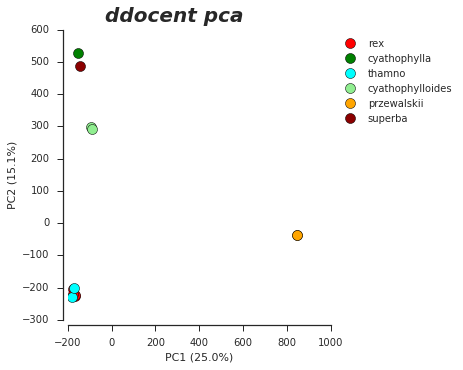

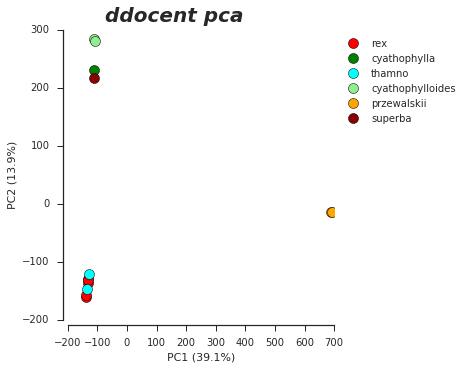

In [238]:
for dset in [[v_full, c_full], [v_filt, c_filt]]:
    plotPCA(dset[1], "ddocent")

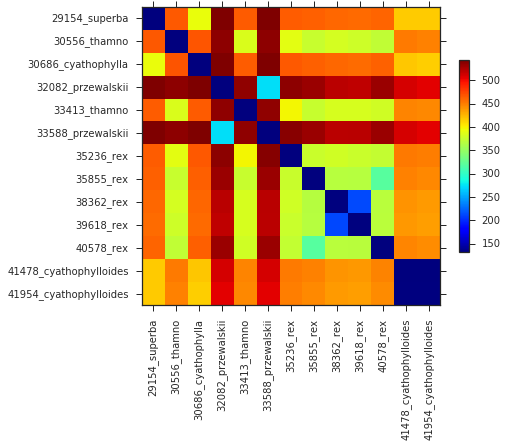

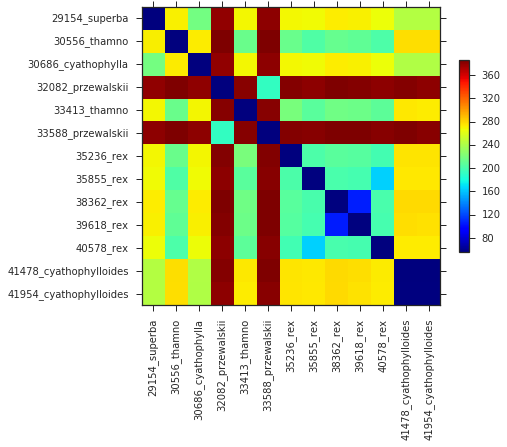

In [239]:
plotPairwiseDistance(c_full, "dDocent Full")
plotPairwiseDistance(c_filt, "dDocent Filtered")

# Everything Below here is crap!

# Everything Below here is crap!

# Everything Below here is crap!

In [49]:
## Maybe useful
print(v.ID)
print(len(v.ID))
print(len(set([x.split("_")[0] for x in v.ID])))


['1_6' '1_14' '1_27' ..., '614361_45' '614386_71' '614406_58']
344633
76984


In [37]:
import itertools
import numpy.ma as ma
print(v.ID)
print(len(v.ID))
loc_list = []
loci = set([x.split("_")[0] for x in v.ID])
print(len(loci))
loc_list = [list(val) for key,val in itertools.groupby(v.ID,key=lambda x:x.split("_")[0])]

print(len(loc_list))
## experimentation
print(v.dtype)
print(c.dtype)

print(np.mean(c.DP))
print(loc_list[0:10])
subsamp = np.array([np.random.choice(x, 1, replace=False)[0] for x in loc_list])
mask = np.in1d(v.ID, subsamp)

['4_35' '4_62' '5_56' ..., '496594_58' '496602_66' '496604_59']
149570
82955
82955
(numpy.record, [('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AF', '<f2'), ('NS', '<i4')])
(numpy.record, [('is_called', '?'), ('is_phased', '?'), ('genotype', 'i1', (2,)), ('AD', '<u2', (2,)), ('DP', '<u2'), ('GL', '<f4'), ('GT', 'S3')])
5.95418198837
[['4_35', '4_62'], ['5_56', '5_62', '5_68'], ['6_61', '6_68'], ['7_67'], ['8_5', '8_41', '8_65'], ['11_40'], ['13_49', '13_71'], ['15_6', '15_10', '15_24', '15_34'], ['16_26'], ['17_17', '17_26', '17_27', '17_66']]


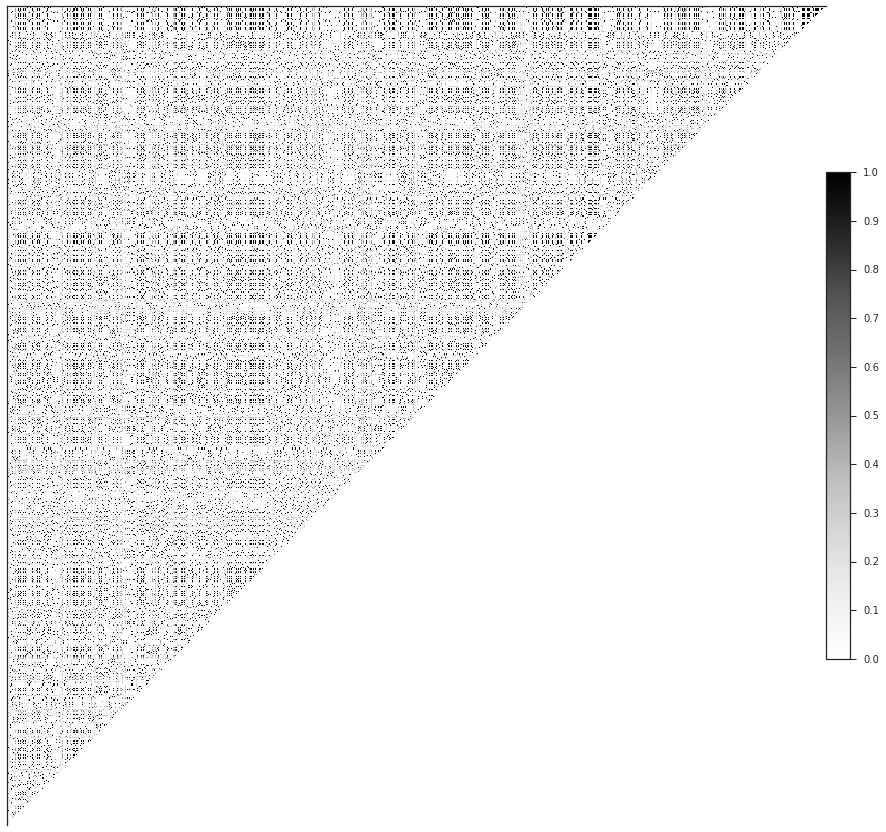

In [55]:
g = allel.GenotypeArray(cmask.genotype)
gn = g.to_n_alt()
m = allel.stats.rogers_huff_r(gn[:1000]) ** 2
ax = allel.plot.pairwise_ld(m)

In [191]:
filename = os.path.join(DDOCENT_OUTPUT, "Final.recode.snps.vcf")
v_filt = vcfnp.variants(filename).view(np.recarray)
c_filt = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-06 21:43:30.965523 :: caching is disabled
[vcfnp] 2016-10-06 21:43:30.966488 :: building array
[vcfnp] 2016-10-06 21:43:42.021230 :: caching is disabled
[vcfnp] 2016-10-06 21:43:42.029759 :: building array


In [194]:
from collections import Counter
print(v_filt.dtype)
#wat = Counter(vcall["POS"])
#wat
## DDOCENT
v_filt["is_snp"]
print(v_filt[0:1])
print(v_filt["NS"][:40])
print(v_filt["NUMALT"][:40])
print(v_filt["ALT"][:40])

(numpy.record, [('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AB', '<f4'), ('ABP', '<f4'), ('AC', '<u2'), ('AF', '<f2'), ('AN', '<u2'), ('AO', '<i4'), ('CIGAR', 'S12'), ('DP', '<i4'), ('DPB', '<f4'), ('DPRA', '<f4'), ('END', '<i4'), ('EPP', '<f4'), ('EPPR', '<f4'), ('GTI', '<i4'), ('LEN', '<i4'), ('MEANALT', '<f4'), ('MIN_DP', '<i4'), ('MQM', '<f4'), ('MQMR', '<f4'), ('NS', '<i4'), ('NUMALT', '<i4'), ('ODDS', '<f4'), ('PAIRED', '<f4'), ('PAIREDR', '<f4'), ('PAO', '<f4'), ('PQA', '<f4'), ('PQR', '<f4'), ('PRO', '<f4'), ('QA', '<i4'), ('QR', '<i4'), ('RO', '<i4'), ('RPL', '<f4'), ('RPP', '<f4'), ('RPPR', '<f4'), ('RPR', '<f4'), ('RUN', '<i4'), ('SAF', '<i4'), ('SAP', '<f4'), ('SAR', '<i4'), ('SRF', '<i4'), ('SRP', '<f4'), ('SRR', '<i4'), ('TYPE', 'S12'), ('technology.Illumina', '<f4')])
[ ('dDocent_Cont', 7, '.', 'T', 'A', 9108.900390625, (False,), 

In [217]:
c_filt[0]

rec.array([ (True, True, array([0, 1], dtype=int8), array([0, 0], dtype=int32), 0, array([0, 0], dtype=int32), array([ 0.,  0.,  0.], dtype=float32), 0, '0|1', 0, array([0, 0], dtype=int32), 0, 0),
 (True, True, array([0, 2], dtype=int8), array([0, 0], dtype=int32), 0, array([0, 0], dtype=int32), array([ 0.,  0.,  0.], dtype=float32), 0, '0|2', 0, array([0, 0], dtype=int32), 0, 0),
 (True, True, array([1, 2], dtype=int8), array([0, 0], dtype=int32), 0, array([0, 0], dtype=int32), array([ 0.,  0.,  0.], dtype=float32), 0, '1|2', 0, array([0, 0], dtype=int32), 0, 0),
 (True, True, array([1, 1], dtype=int8), array([0, 0], dtype=int32), 0, array([0, 0], dtype=int32), array([ 0.,  0.,  0.], dtype=float32), 0, '1|1', 0, array([0, 0], dtype=int32), 0, 0),
 (True, True, array([0, 1], dtype=int8), array([0, 0], dtype=int32), 0, array([0, 0], dtype=int32), array([ 0.,  0.,  0.], dtype=float32), 0, '0|1', 0, array([0, 0], dtype=int32), 0, 0),
 (True, True, array([0, 1], dtype=int8), array([0, 0],

In [203]:
v

rec.array([], 
          dtype=[('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AA', 'S12'), ('AF', '<f2'), ('DP', '<i4'), ('NS', '<i4')])